In [1]:
# Run this cell to download required libraries for BioMedCliP.
!pip install open_clip_torch transformers matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

# Improvement - Finetuning BioMedCLiP for Binary Classification

### Improvements proposed:

1. Introduction of classification head that utilizes both image and text embeddings.
2. Mitigating class imbalance by introducing new but similar slides of the imbalanced class.
3. Finetuning of BioMedCLiP with the new classification head as well as updating parameters of the last two visual transformer layers and the visual projection head for binary detection of dementia caused by Alzheimer's disease.


In [2]:
# General Libraries.
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import random
import torch
import glob
import json
import cv2
import os

# Libraries for BioMedCLiP.
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv('filtered_oasis_1.csv')
cdr_labels = {
    0.0: 'Non-Demented',
    0.5: 'Very Mild Dementia',
    1.0: 'Mild Dementia',
    2.0: 'Moderate Dementia',
    3.0: 'Severe Dementia'
}

df['CDR_Labels'] = df['CDR'].map(cdr_labels)
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,CDR_Labels
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,Non-Demented
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,Non-Demented
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,Very Mild Dementia
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN,Non-Demented
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN,Non-Demented


In [5]:
# Download latest version of OASIS-1 images.
path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagesoasis


In [6]:
BASE_PATH = path
IMAGE_PATHS = glob.glob(f'{BASE_PATH}/**/*.jpg',recursive=True)
print("Number of raw images:", len(IMAGE_PATHS))

Number of raw images: 86437


In [7]:
MPR1_IMAGE_PATHS = [image_path for image_path in IMAGE_PATHS if '_mpr-1_' in image_path]
print("Sample paths:")
for idx in range(5):
    print(MPR1_IMAGE_PATHS[idx])

Sample paths:
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0114_MR1_mpr-1_130.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0375_MR1_mpr-1_136.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0159_MR1_mpr-1_131.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0198_MR1_mpr-1_137.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0181_MR1_mpr-1_104.jpg


In [8]:
# Extract patient IDs and CDR labels while maintaining the relationship
patient_data = df[['ID', 'CDR_Labels']].sort_values(by=['ID']).reset_index(drop=True)

patient_ids = patient_data['ID'].tolist()
cdr_labels_list = patient_data['CDR_Labels'].tolist()

for i in range(len(patient_ids)):
    print(f"Patient ID: {patient_ids[i]}, CDR Label: {cdr_labels_list[i]}")

Patient ID: OAS1_0001_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0002_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0003_MR1, CDR Label: Very Mild Dementia
Patient ID: OAS1_0004_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0005_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0006_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0007_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0009_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0010_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0011_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0012_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0013_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0014_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0015_MR1, CDR Label: Very Mild Dementia
Patient ID: OAS1_0016_MR1, CDR Label: Very Mild Dementia
Patient ID: OAS1_0017_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0018_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0019_MR1, CDR Label: Non-Demented
Patient ID: OAS1_0020_MR1, CDR Label: Non-Demented
Patient ID: O


Class Imbalance (Combined Demented Class):
Non-Demented: 77.87%
Demented: 22.13%


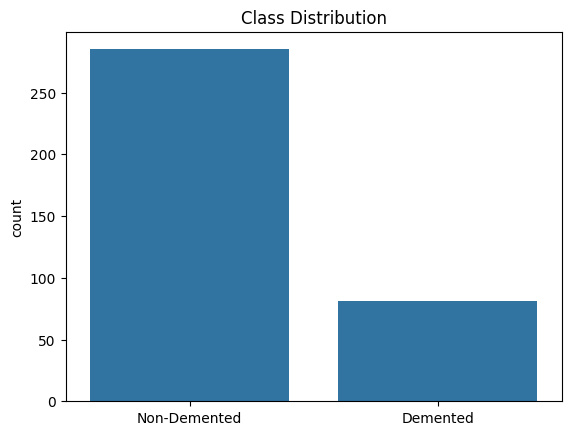

In [21]:
from collections import Counter

label_counts = Counter(cdr_labels_list)
demented_labels = [label for label in cdr_labels_list if label not in ['Non-Demented']]
combined_labels = ['Demented' if label in demented_labels else label for label in cdr_labels_list]
combined_label_counts = Counter(combined_labels)


print("\nClass Imbalance (Combined Demented Class):")
total_combined_labels = sum(combined_label_counts.values())
for label, count in combined_label_counts.items():
    percentage = (count / total_combined_labels) * 100
    print(f"{label}: {percentage:.2f}%")


sns.countplot(x=combined_labels)
plt.title("Class Distribution")
plt.show()


In [39]:
def select_images(patient_id, select_one=False, demented = False):
    img_list = [image_path for image_path in MPR1_IMAGE_PATHS if f"_{patient_id}_" in image_path]
    img_list.sort()
    if (select_one):
        if img_list:
          if not demented:
            return [img_list[len(img_list) // 2]]
          else:
            middle_slice = len(img_list) // 2
            return [img_list[middle_slice - 1], img_list[middle_slice], img_list[middle_slice + 1]]
        else:
          return []
    else:
        return img_list

random_id = random.choice(patient_ids).split('_')[1]
random_id = "0316"
print(f"Selected random ID: {random_id}")
selected_images = select_images(random_id, select_one=True, demented=True)

selected_images

Selected random ID: 0316


['/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0316_MR1_mpr-1_129.jpg',
 '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0316_MR1_mpr-1_130.jpg',
 '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0316_MR1_mpr-1_131.jpg']

## Mapping functions for Binary Classification

In [40]:
def map_cdr_to_binary_label(cdr_label):
    if cdr_label == 'Non-Demented':
        return 0
    else:
        return 1

def map_binary_label_to_cdr(label):
    if label == 0:
        return "Non-Demented"
    else:
        return "Demented"

## Image Captioning

In [47]:
# Define the context for the scores
score_context = {
    'MMSE': "MMSE (Mini-Mental State Examination) is a cognitive assessment used to evaluate cognitive function. A score of 24-30 indicates normal cognitive function, while scores below 24 suggest cognitive impairment.",
    'eTIV': "eTIV (estimated Total Intracranial Volume) measures the volume of the skull, which is related to brain size. The normal range varies based on age and sex, but it's generally around 1400-1600 cm^3.",
    'nWBV': "nWBV (normalized Whole Brain Volume) is the proportion of the brain's volume relative to the total intracranial volume. A higher percentage generally suggests better brain health, with a range from ~70% to 85%.",
    'ASF': "ASF (Atlas Scaling Factor) adjusts the image to match a reference template. Values around 1 indicate good alignment, while values significantly higher or lower may indicate problems with the scaling or registration process.",
    'CDR': "CDR (Clinical Dementia Rating) is used to assess the severity of dementia. A score of 0 indicates no dementia, 0.5 suggests very mild dementia, 1 indicates mild dementia, 2 indicates moderate dementia, and 3 indicates severe dementia."
}

# Function to handle missing or unavailable values
def handle_missing_value(value, column_name):
    if pd.isna(value) or value == -1:
        return "Information unavailable."
    return str(value)

# Function to generate the caption for each image
def generate_caption(row):
    caption = (
        f"Patient ID: {row['ID']},\n"
        f"Gender: {row['M/F']}, Handedness: {row['Hand']}, Age: {row['Age']} years,\n"
        f"Education: {handle_missing_value(row['Educ'], 'Education')},\n"
        f"Socioeconomic Status: {handle_missing_value(row['SES'], 'Socioeconomic Status')},\n"
        f"MMSE: {handle_missing_value(row['MMSE'], 'MMSE')} ({score_context.get('MMSE', '')}),\n"
        f"eTIV: {handle_missing_value(row['eTIV'], 'eTIV')} ({score_context.get('eTIV', '')}),\n"
        f"nWBV: {handle_missing_value(row['nWBV'], 'nWBV')} ({score_context.get('nWBV', '')}),\n"
        f"ASF: {handle_missing_value(row['ASF'], 'ASF')} ({score_context.get('ASF', '')}).\n"
        f"CDR: {handle_missing_value(row['CDR'], 'CDR')} ({score_context.get('CDR', '')}).\n"
    )

    return caption

# Binary classification.
image_path_to_captions = {}
for i in range(len(patient_ids)):
  current_id = patient_ids[i].split('_')[1]
  current_label = cdr_labels_list[i]
  binary_label = map_cdr_to_binary_label(current_label)

  # Add additional images for demented examples.
  if binary_label == 1:
    selected_images = select_images(current_id, select_one=True, demented=True)
  else:
    selected_images = select_images(current_id, select_one=True)

  # Generate captions for each image in the selected images list.
  for idx, image_path in enumerate(selected_images):
    if (len(selected_images) != 0):
      patient_id = image_path.split('/')[-1].split('_')[0] + '_' + image_path.split('\\')[-1].split('_')[1]+"_MR1"
      patient_data = df[df['ID'] == patient_id]
      if patient_data.empty:
          print(f"Warning: No data found for patient ID {patient_id}. Skipping image {image_path}.")
          continue
      patient_data = patient_data.iloc[0]
      caption = generate_caption(patient_data)
      label = map_cdr_to_binary_label(patient_data['CDR_Labels'])
      image_path_to_captions[selected_images[idx]] = (caption, binary_label)
      df.loc[df['ID'] == patient_id, 'CustomCaption'] = caption


## BioMedCLiP Setup

In [13]:
# Download the model and config files.
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)

hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)

# Load the BiomedCLiP model and tokenizer.
model_name = "biomedclip_local"

with open("checkpoints/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]

if (not model_name.startswith(HF_HUB_PREFIX)
        and model_name not in _MODEL_CONFIGS
        and config is not None):
    _MODEL_CONFIGS[model_name] = model_cfg

# Load model, tokenizer, and preprocessing function.
model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

tokenizer = get_tokenizer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

## Dataset Creation

In [49]:
from torch.utils.data import Dataset

def process_image(image_path, preprocess, device, show = False):
    original = Image.open(image_path)
    image = cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (224, 224))
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    processed = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    image_input = preprocess(processed)

    return image_input


class BioMedCLIPDataset(Dataset):
    def __init__(self, image_pth_to_captions, tokenizer, preprocess, device):
        self.samples = list(image_pth_to_captions.items())
        self.tokenizer = tokenizer
        self.preprocess = preprocess
        self.device = device

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, caption_w_label = self.samples[idx]
        caption, label = caption_w_label

        image_tensor = process_image(image_path, self.preprocess, self.device)
        text_tokens = self.tokenizer(caption).squeeze(0)

        return image_tensor, text_tokens, label

## Checking Class Imbalance

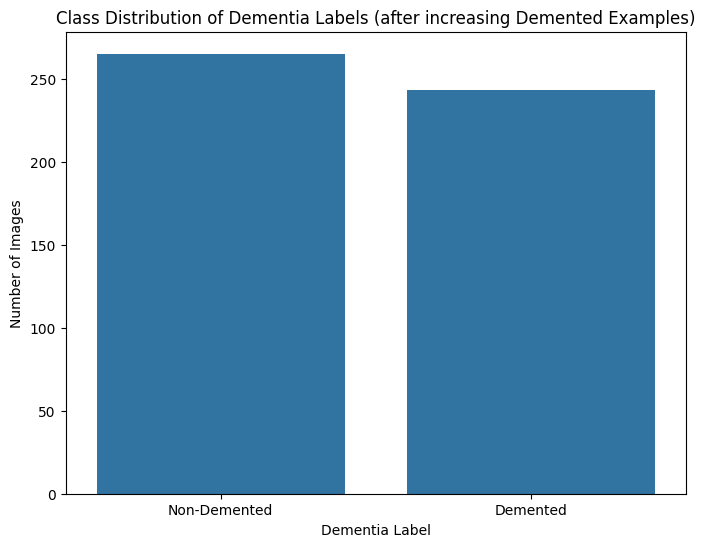

In [51]:
label_counts = {}
for image_path, (caption, label) in image_path_to_captions.items():
    label_str = map_binary_label_to_cdr(label)
    label_counts[label_str] = label_counts.get(label_str, 0) + 1

labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts)
plt.title("Class Distribution of Dementia Labels (after increasing Demented Examples)")
plt.xlabel("Dementia Label")
plt.ylabel("Number of Images")
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

image_caption_items = list(image_path_to_captions.items())
train_items, val_items = train_test_split(image_caption_items, test_size=0.2, random_state=42)

train_dataset = BioMedCLIPDataset(dict(train_items), tokenizer, preprocess, device)
val_dataset = BioMedCLIPDataset(dict(val_items), tokenizer, preprocess, device)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [53]:
# Check data shapes.
for batch_idx, (image_input, text_input, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Image Input Shape: {image_input.shape}")
    print(f"Text Input Shape: {text_input.shape}")
    print(f"Labels: {labels}")

    if batch_idx == 0:
      break

Batch 1:
Image Input Shape: torch.Size([1, 3, 224, 224])
Text Input Shape: torch.Size([1, 256])
Labels: tensor([0])


## Training Loop and Loss Visualization

Training Epoch 1:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6331
Validation Accuracy: 83.33%


Training Epoch 2:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4418
Validation Accuracy: 81.37%


Training Epoch 3:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.3230
Validation Accuracy: 83.33%


Training Epoch 4:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.1984
Validation Accuracy: 87.25%


Training Epoch 5:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0903
Validation Accuracy: 81.37%


Training Epoch 6:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0451
Validation Accuracy: 90.20%


Training Epoch 7:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0136
Validation Accuracy: 92.16%


Training Epoch 8:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0032
Validation Accuracy: 93.14%


Training Epoch 9:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0015
Validation Accuracy: 94.12%


Training Epoch 10:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0008
Validation Accuracy: 92.16%


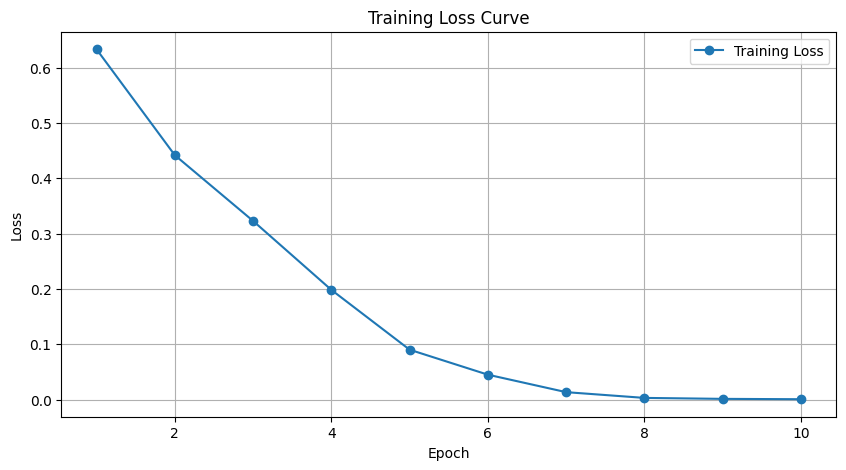

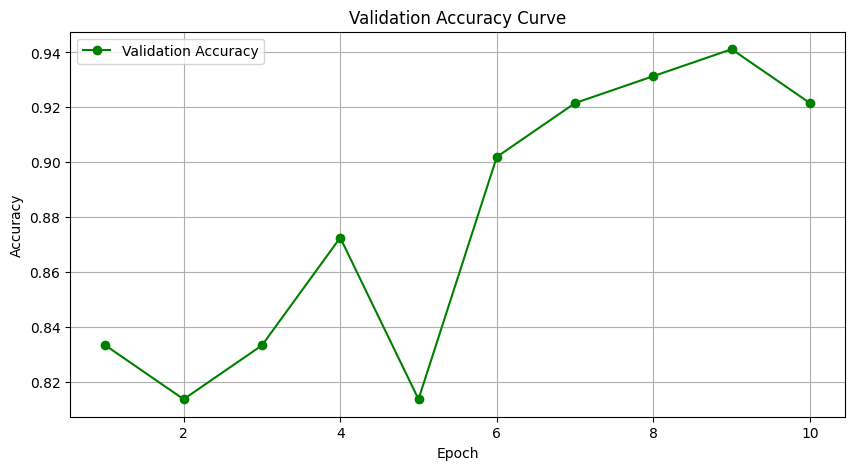

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Define fine-tuning configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
learning_rate = 1e-5

model.to(device)

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two transformer blocks in the visual encoder
for block in model.visual.trunk.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# Optionally, unfreeze the projection head as well
for param in model.visual.head.parameters():
    param.requires_grad = True

# Classification Head (multimodal: image + text embeddings)
classifier = nn.Sequential(
    nn.Linear(512 + 512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1)
).to(device)

# Define optimizer and loss criterion
optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, model.parameters())) + list(classifier.parameters()), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Containers for plotting
train_losses = []
val_accuracies = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, captions, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        images = images.to(device)
        captions = captions.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        image_embeddings = model.encode_image(images)
        text_embeddings = model.encode_text(captions)

        combined_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        outputs = classifier(combined_embeddings)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, captions, labels in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            image_embeddings = model.encode_image(images)
            text_embeddings = model.encode_text(captions)

            combined_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
            outputs = classifier(combined_embeddings)

            predictions = (torch.sigmoid(outputs) > 0.5).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    val_accuracy = total_correct / total_samples
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

# Plot validation accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
# Saving Model
torch.save(model.state_dict(), 'biomedclip_finetuned_balanced.pth')

## Evaluation of Finetuned Model (with caption)

In [67]:
# Evaluation Loop
model.eval()
classifier.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, captions, labels in val_loader:
        images = images.to(device)
        captions = captions.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        image_embeddings = model.encode_image(images)
        text_embeddings = model.encode_text(captions)

        combined_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        outputs = classifier(combined_embeddings)

        predictions = torch.sigmoid(outputs).cpu().numpy()

        all_preds.extend(predictions)
        all_labels.extend(labels.cpu().numpy())


Accuracy: 93.14%
AUC Score: 0.9754


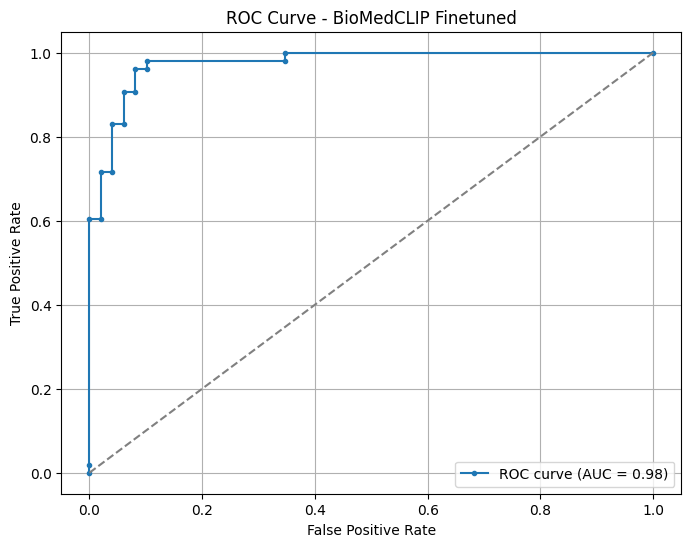

In [68]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

accuracy = accuracy_score(all_labels, binary_preds)
auc_score = roc_auc_score(all_labels, all_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BioMedCLIP Finetuned')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation of finetuned model (with a generic caption)

In [78]:
# Evaluation Loop
model.eval()
classifier.eval()

all_labels_generic = []
all_preds_generic = []

generic_caption = "This is a brain MRI scan for neurodegenerative disease diagnosis."

with torch.no_grad():
    for images, _ , labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        generic_caption_tokenized = tokenizer([generic_caption] * images.size(0)).to(device)

        image_embeddings = model.encode_image(images)
        text_embeddings = model.encode_text(generic_caption_tokenized)

        combined_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        outputs = classifier(combined_embeddings)

        predictions = torch.sigmoid(outputs).cpu().numpy()

        all_preds_generic.extend(predictions)
        all_labels_generic.extend(labels.cpu().numpy())


Accuracy: 93.14%
AUC Score: 0.9761


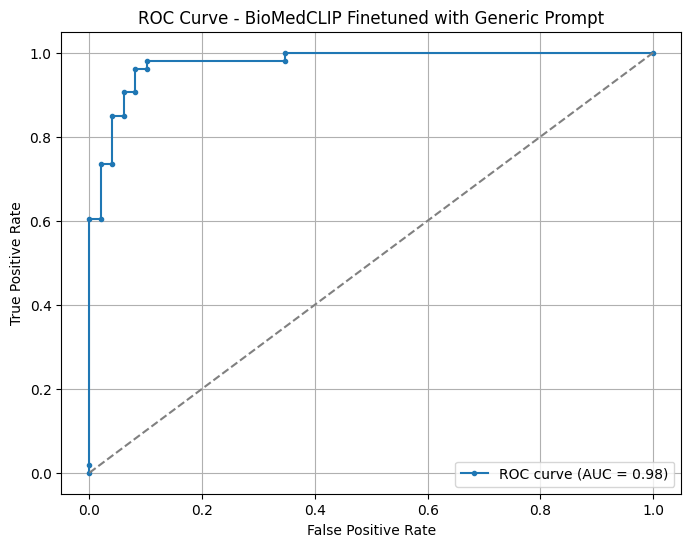

In [79]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

binary_preds_generic = [1 if p >= 0.5 else 0 for p in all_preds_generic]

accuracy = accuracy_score(all_labels_generic, binary_preds_generic)
auc_score = roc_auc_score(all_labels_generic, all_preds_generic)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(all_labels_generic, all_preds_generic)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BioMedCLIP Finetuned with Generic Prompt')
plt.legend()
plt.grid(True)
plt.show()


## Comparison of tuned BioMedCLiP vs. Base Model

In [58]:
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)

hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)

model_name = "biomedclip_untuned"

with open("checkpoints/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]

if (not model_name.startswith(HF_HUB_PREFIX)
        and model_name not in _MODEL_CONFIGS
        and config is not None):
    _MODEL_CONFIGS[model_name] = model_cfg

# Load model, tokenizer, and preprocessing function.
base_model_untuned, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

tokenizer = get_tokenizer(model_name)

## Prompt Analysis:



### Prompt 1: The brain MRI scan of this patient is likely to be classified as ...

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to evaluate a model with fixed prompt for each class.
def evaluate_model(model, prompts, classifier=None, use_classifier=False, title='Confusion Matrix'):
    model.eval()

    if classifier:
        classifier.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, captions, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).long().view(-1)

            # Encode both prompts
            prompt_tokens = tokenizer(prompts).to(device)

            if use_classifier:
                image_embeddings = model.encode_image(images)
                text_embeddings = model.encode_text(prompt_tokens)

                scores = []
                for text_embed in text_embeddings:
                    repeated_text = text_embed.unsqueeze(0).expand(image_embeddings.size(0), -1)
                    combined = torch.cat((image_embeddings, repeated_text), dim=1)
                    logits = classifier(combined)
                    probs = torch.sigmoid(logits).cpu().numpy().flatten()
                    scores.append(probs)

                scores = np.stack(scores, axis=1)
                predicted_probs = scores.max(axis=1)
                predicted_labels = scores.argmax(axis=1)

            else:
                # Direct use of model's forward pass for similarity
                image_features, text_features, logit_scale = model(images, prompt_tokens)
                logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)
                predicted_labels = logits.argmax(dim=1).cpu().numpy()
                predicted_probs = logits[:, 1].cpu().numpy()

            all_preds.extend(predicted_probs)
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels).astype(int).flatten()

    acc = accuracy_score(all_labels, all_preds >= 0.5)
    auc = roc_auc_score(all_labels, all_preds)

    pred_binary = (all_preds >= 0.5).astype(int)
    conf = confusion_matrix(all_labels, pred_binary, labels=[0,1])
    class0_acc = conf[0, 0] / conf[0].sum() if conf[0].sum() > 0 else 0
    class1_acc = conf[1, 1] / conf[1].sum() if conf[1].sum() > 0 else 0

    conf_labels = ["Non-Demented", "Demented"]

    plt.figure(figsize=(8, 5))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=conf_labels, yticklabels=conf_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return acc, auc, class0_acc, class1_acc

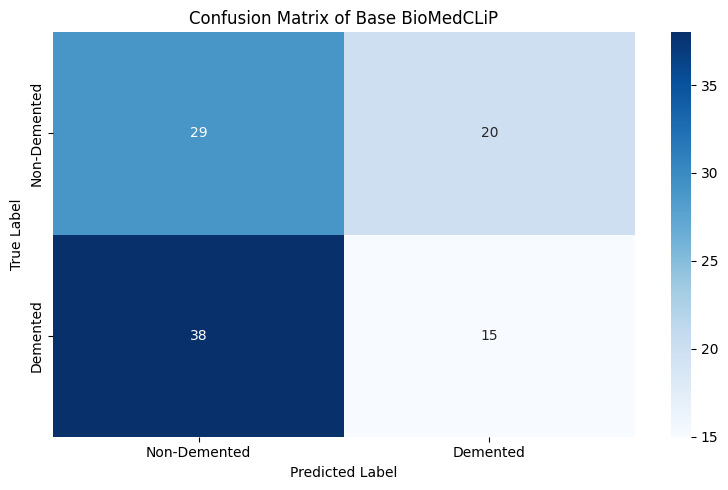

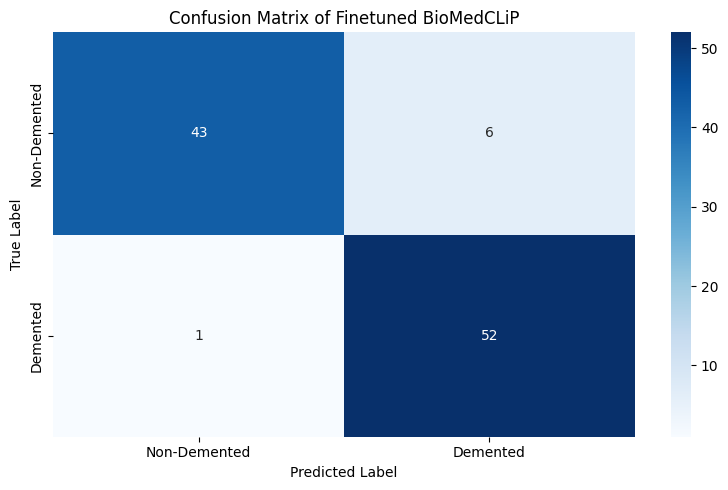

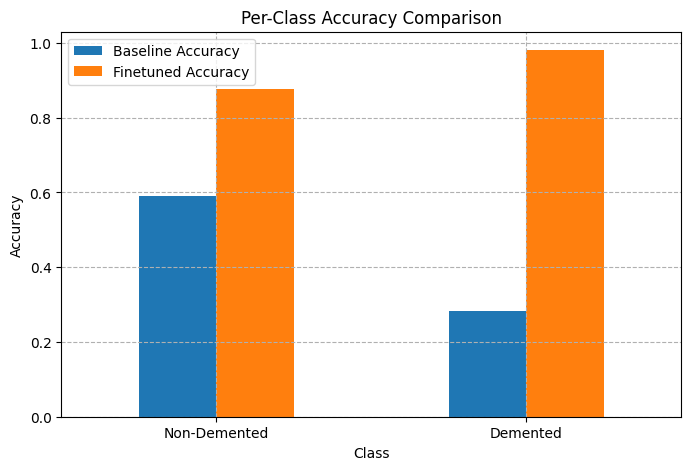

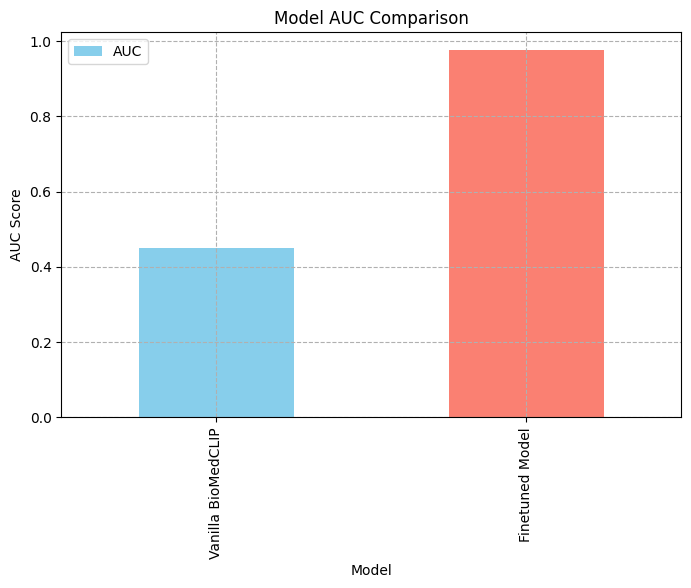

--- Comparative Results ---
Vanilla BioMedCLIP: Accuracy = 0.4314, AUC = 0.4509
Finetuned Model:    Accuracy = 0.9314, AUC = 0.9754


In [83]:
prompts = [
    "The brain MRI scan of this patient is likely to be classified as Non-Demented.",
    "The brain MRI scan of this patient is likely to be classified as Demented."
]


# Evaluate models.
baseline_acc, baseline_auc, baseline_class0_acc, baseline_class1_acc = evaluate_model(base_model_untuned.to(device), prompts, use_classifier=False, title='Confusion Matrix of Base BioMedCLiP')
finetuned_acc, finetuned_auc, finetuned_class0_acc, finetuned_class1_acc = evaluate_model(model,prompts, classifier, use_classifier=True, title='Confusion Matrix of Finetuned BioMedCLiP')

comparison_df = pd.DataFrame({
    'Class': ['Non-Demented', 'Demented'],
    'Baseline Accuracy': [baseline_class0_acc, baseline_class1_acc],
    'Finetuned Accuracy': [finetuned_class0_acc, finetuned_class1_acc]
})

comparison_df.plot(x='Class', y=['Baseline Accuracy', 'Finetuned Accuracy'], kind='bar', figsize=(8, 5))
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.show()

auc_df = pd.DataFrame({
    'Model': ['Vanilla BioMedCLIP', 'Finetuned Model'],
    'AUC': [baseline_auc, finetuned_auc]
})

auc_df.plot(x='Model', y='AUC', kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.ylabel('AUC Score')
plt.title('Model AUC Comparison')
plt.grid(True, linestyle='--')
plt.show()


print("--- Comparative Results ---")
print(f"Vanilla BioMedCLIP: Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned Model:    Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")


### Prompt 2: A medical expert looking to assess for a neuro-degenerative disease would likely classify this as ...

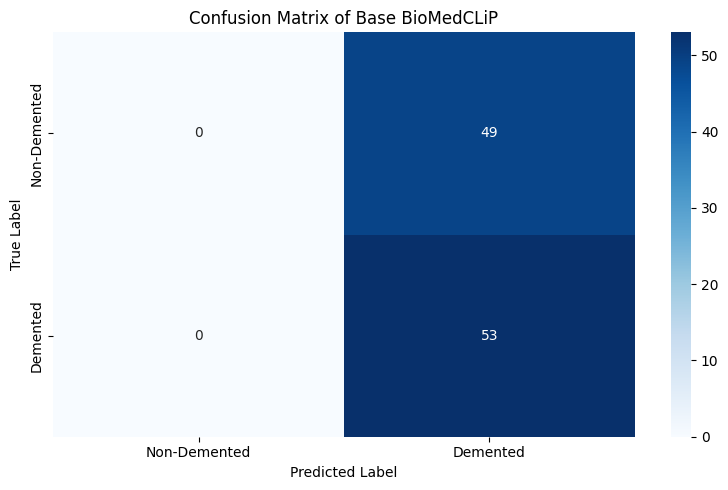

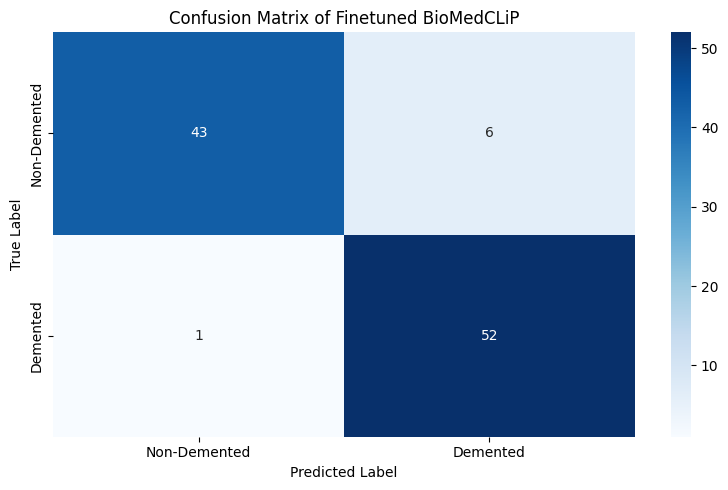

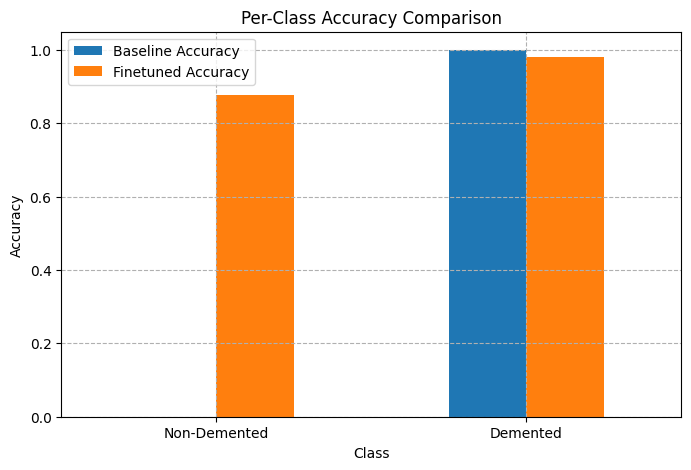

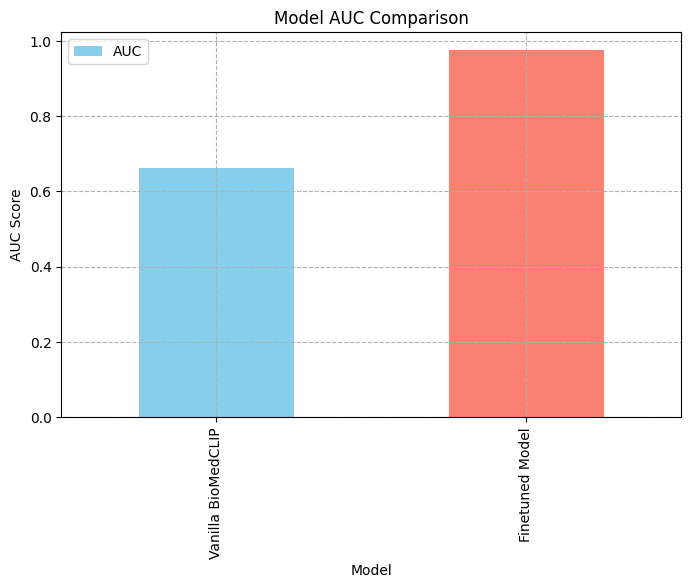

--- Comparative Results ---
Vanilla BioMedCLIP: Accuracy = 0.5196, AUC = 0.6631
Finetuned Model:    Accuracy = 0.9314, AUC = 0.9750


In [84]:
prompts = [
    "A medical expert looking to assess for a neuro-degenerative disease would likely classify this as Non-Demented.",
    "A medical expert looking to assess for a neuro-degenerative disease would likely classify this as Demented."
]

# Evaluate models.
baseline_acc, baseline_auc, baseline_class0_acc, baseline_class1_acc = evaluate_model(base_model_untuned.to(device), prompts, use_classifier=False, title='Confusion Matrix of Base BioMedCLiP')
finetuned_acc, finetuned_auc, finetuned_class0_acc, finetuned_class1_acc = evaluate_model(model,prompts, classifier, use_classifier=True, title='Confusion Matrix of Finetuned BioMedCLiP')

comparison_df = pd.DataFrame({
    'Class': ['Non-Demented', 'Demented'],
    'Baseline Accuracy': [baseline_class0_acc, baseline_class1_acc],
    'Finetuned Accuracy': [finetuned_class0_acc, finetuned_class1_acc]
})

comparison_df.plot(x='Class', y=['Baseline Accuracy', 'Finetuned Accuracy'], kind='bar', figsize=(8, 5))
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.show()

auc_df = pd.DataFrame({
    'Model': ['Vanilla BioMedCLIP', 'Finetuned Model'],
    'AUC': [baseline_auc, finetuned_auc]
})

auc_df.plot(x='Model', y='AUC', kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.ylabel('AUC Score')
plt.title('Model AUC Comparison')
plt.grid(True, linestyle='--')
plt.show()


print("--- Comparative Results ---")
print(f"Vanilla BioMedCLIP: Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned Model:    Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")

### Prompt 3: Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer's disease:

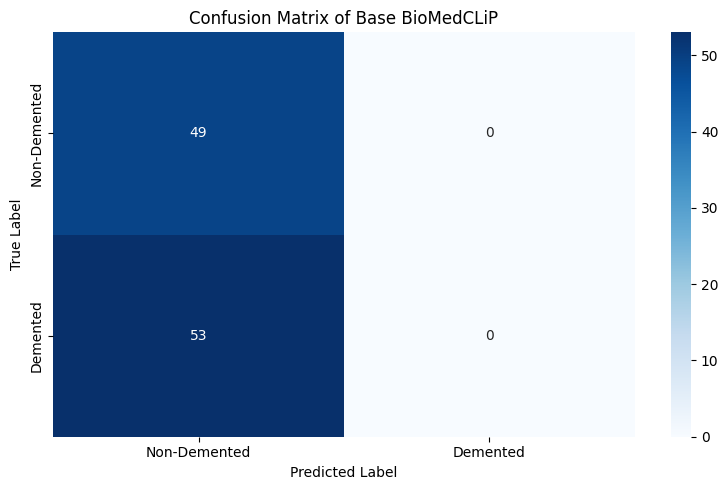

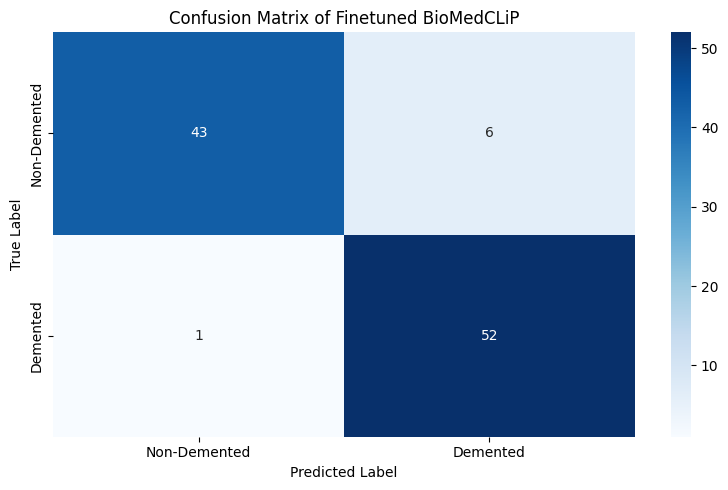

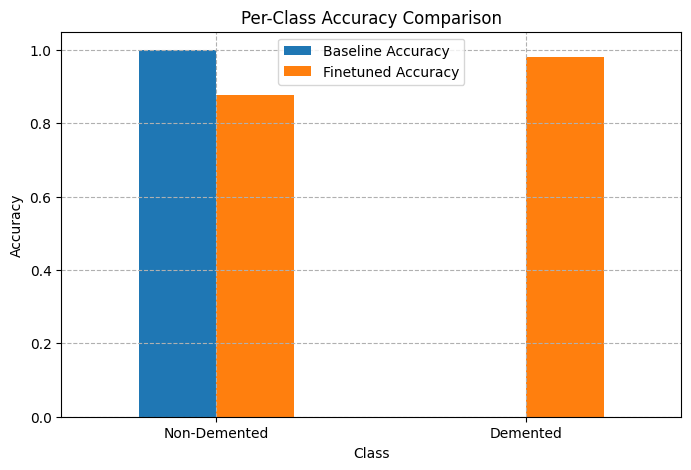

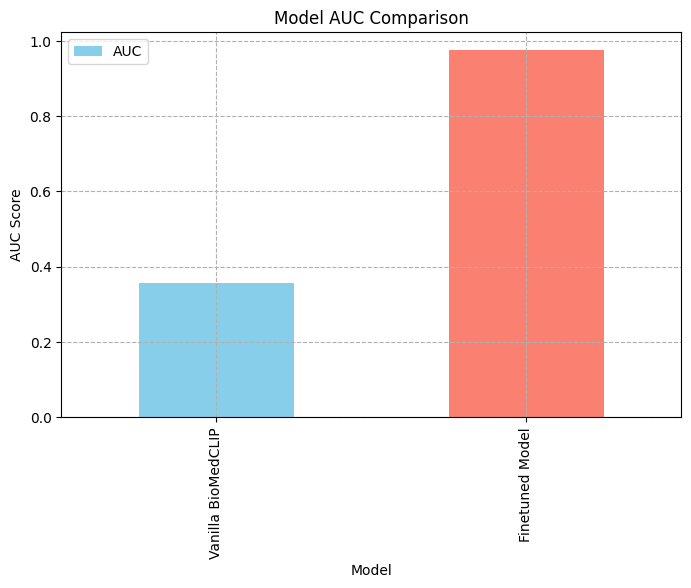

--- Comparative Results ---
Vanilla BioMedCLIP: Accuracy = 0.4804, AUC = 0.3558
Finetuned Model:    Accuracy = 0.9314, AUC = 0.9750


In [85]:
prompts = [
    "Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer\'s disease: Demented.",
    "Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer\'s disease: Non-Demented."
]

# Evaluate models.
baseline_acc, baseline_auc, baseline_class0_acc, baseline_class1_acc = evaluate_model(base_model_untuned.to(device), prompts, use_classifier=False, title='Confusion Matrix of Base BioMedCLiP')
finetuned_acc, finetuned_auc, finetuned_class0_acc, finetuned_class1_acc = evaluate_model(model,prompts, classifier, use_classifier=True, title='Confusion Matrix of Finetuned BioMedCLiP')

comparison_df = pd.DataFrame({
    'Class': ['Non-Demented', 'Demented'],
    'Baseline Accuracy': [baseline_class0_acc, baseline_class1_acc],
    'Finetuned Accuracy': [finetuned_class0_acc, finetuned_class1_acc]
})

comparison_df.plot(x='Class', y=['Baseline Accuracy', 'Finetuned Accuracy'], kind='bar', figsize=(8, 5))
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.show()

auc_df = pd.DataFrame({
    'Model': ['Vanilla BioMedCLIP', 'Finetuned Model'],
    'AUC': [baseline_auc, finetuned_auc]
})

auc_df.plot(x='Model', y='AUC', kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.ylabel('AUC Score')
plt.title('Model AUC Comparison')
plt.grid(True, linestyle='--')
plt.show()


print("--- Comparative Results ---")
print(f"Vanilla BioMedCLIP: Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned Model:    Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")

## Base BioMedCLiP vs. FineTuned BioMedCLiP (Without the Classification Head)

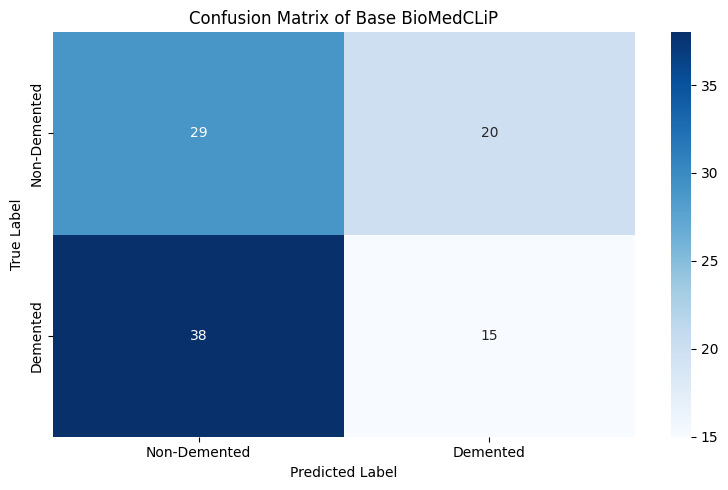

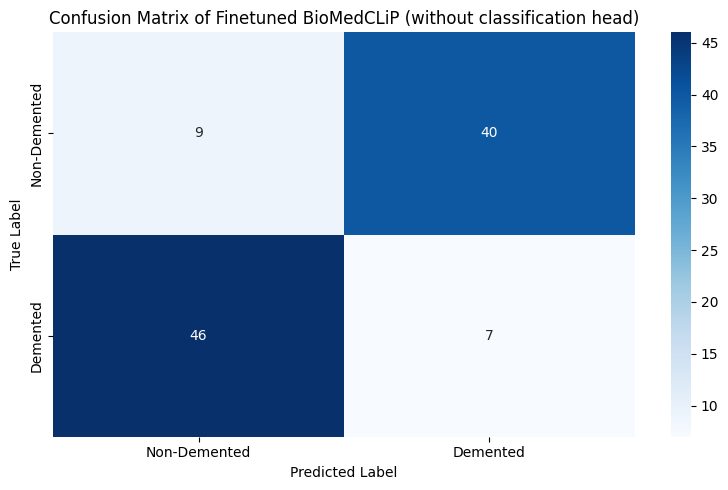

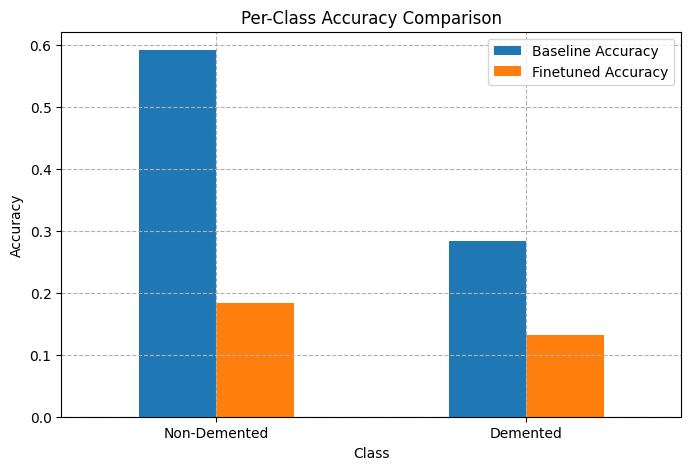

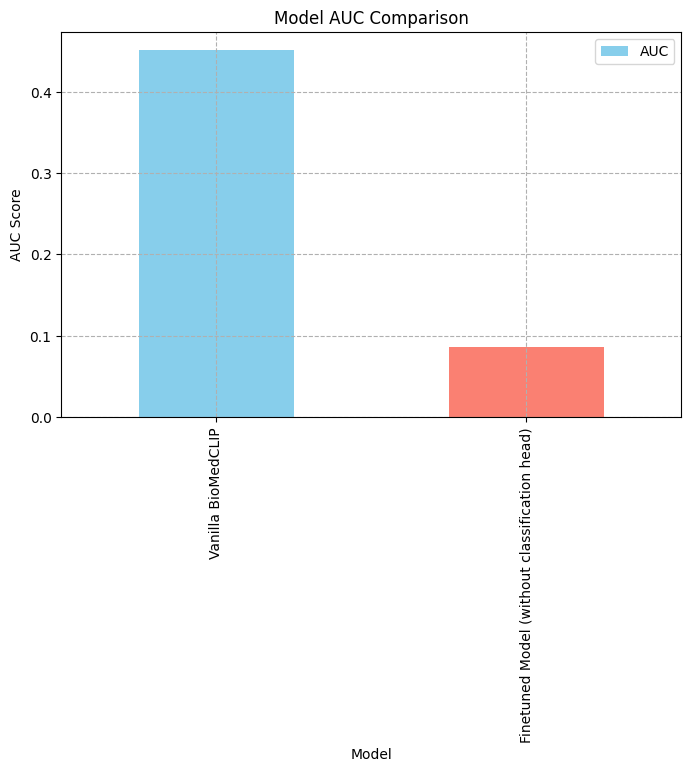

--- Comparative Results ---
Vanilla BioMedCLIP: Accuracy = 0.4314, AUC = 0.4509
Finetuned Model (without classification head):    Accuracy = 0.1569, AUC = 0.0863


In [86]:
prompts = [
    "The brain MRI scan of this patient is likely to be classified as Non-Demented.",
    "The brain MRI scan of this patient is likely to be classified as Demented."
]


# Evaluate models.
baseline_acc, baseline_auc, baseline_class0_acc, baseline_class1_acc = evaluate_model(base_model_untuned.to(device), prompts, use_classifier=False, title='Confusion Matrix of Base BioMedCLiP')
finetuned_acc, finetuned_auc, finetuned_class0_acc, finetuned_class1_acc = evaluate_model(model, prompts, use_classifier=False, title='Confusion Matrix of Finetuned BioMedCLiP (without classification head)')

comparison_df = pd.DataFrame({
    'Class': ['Non-Demented', 'Demented'],
    'Baseline Accuracy': [baseline_class0_acc, baseline_class1_acc],
    'Finetuned Accuracy': [finetuned_class0_acc, finetuned_class1_acc]
})

comparison_df.plot(x='Class', y=['Baseline Accuracy', 'Finetuned Accuracy'], kind='bar', figsize=(8, 5))
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.show()

auc_df = pd.DataFrame({
    'Model': ['Vanilla BioMedCLIP', 'Finetuned Model (without classification head)'],
    'AUC': [baseline_auc, finetuned_auc]
})

auc_df.plot(x='Model', y='AUC', kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.ylabel('AUC Score')
plt.title('Model AUC Comparison')
plt.grid(True, linestyle='--')
plt.show()


print("--- Comparative Results ---")
print(f"Vanilla BioMedCLIP: Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned Model (without classification head):    Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")

## Takeaways:

- The addition of the classification head to BioMedCLiP has substantially increased the accuracy of binary classification when it comes to detecting Dementia caused by Alzheimer's Disease.
- We notice that the classification is not directly improved through finetuning the visual transformer blocks of BioMedCLiP itself. The results very strongly show that the finetuned model performs extremely poorly (much worse than vanilla BioMedCLIP) if the custom classification head is removed. However, with the classification head being incorporated, we notice a significant boost in dementia detection through VLMs, thus implying that the majority of performance gains are attributable to the classification head.
- We again observe the difference that prompts have in the performance of vanilla BioMedCLiP, but not so much with the classification head. Again, further improvements can target the nature of these captions along with the prompts and see which align for better performance.
- The effect of textual embeddings does not seem quite significant, as observed with the different captions and prompts used overall. This can be observed with the section where the validation dataloader is evaluated using the created captions vs. a generic caption. It might be that we have not engineered the perfect caption that makes an impact in the classification head. Another improvement that we could choose would be to explore the context length of the tokenizer and whether that inhibits the contribution of the text prompts into the classification head. Furthermore, subsequent improvements may experiment with replacing the model's vision head, which 